# Task 3: Customer Segmentation / Clustering 🤓

# Import necessary libraries 📲

In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Load the datasets 🖨

In [6]:

customers    =  pd.read_csv("C:/Users/HP/Desktop/ZeoTap/Data/Customers.csv")
transactions =  pd.read_csv("C:/Users/HP/Desktop/ZeoTap/Data/Transactions.csv")


# Understanding the Data 👨🏽‍💻

In [39]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [40]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


# Clustering with K-Means ✌️

In [9]:
# Feature Engineering
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


In [10]:
# Summarize transaction data per customer

transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count'],
    'TransactionDate': ['max', 'min']
}).reset_index()


In [11]:
# Rename columns for clarity
transaction_summary.columns = ['CustomerID', 'TotalSpent', 'AvgSpent', 'Frequency', 'LastPurchaseDate', 'FirstPurchaseDate']


In [12]:
# Calculate Recency (relative to today)
today = pd.Timestamp("2025-01-23")
transaction_summary['Recency'] = (today - transaction_summary['LastPurchaseDate']).dt.days


In [13]:
# Drop date columns after Recency calculation
transaction_summary = transaction_summary.drop(columns=['LastPurchaseDate', 'FirstPurchaseDate'])


In [14]:
# Merge with customer profile data
customers_transactions = pd.merge(customers, transaction_summary, on='CustomerID', how='inner')


In [15]:
# Preprocessing
features = customers_transactions[['Region', 'TotalSpent', 'AvgSpent', 'Frequency', 'Recency']]
numeric_features = ['TotalSpent', 'AvgSpent', 'Frequency', 'Recency']
categorical_features = ['Region']


In [16]:
# Scale numeric features and encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

processed_features = preprocessor.fit_transform(features)


In [17]:
# Determine Optimal Number of Clusters
cluster_range = range(2, 11)
db_scores = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(processed_features)
    db_scores.append(davies_bouldin_score(processed_features, cluster_labels))
    silhouette_scores.append(silhouette_score(processed_features, cluster_labels))

optimal_k = cluster_range[np.argmin(db_scores)]


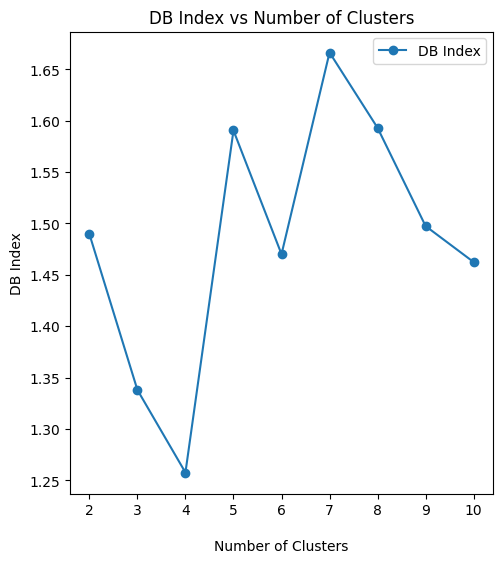

In [43]:
# Plot DB Index and Silhouette Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, db_scores, marker='o', label='DB Index')
plt.title('DB Index vs Number of Clusters')
plt.xlabel('\nNumber of Clusters')
plt.ylabel('DB Index')
plt.legend()


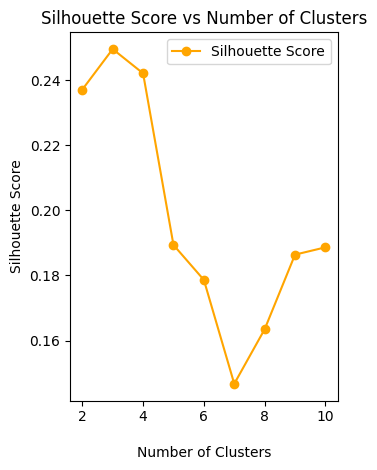

In [42]:
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score', color='orange')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('\nNumber of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
print(f"Optimal number of clusters (k): {optimal_k}")

Optimal number of clusters (k): 4


In [25]:
# Fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(processed_features)

# Add cluster labels to the dataset
customers_transactions['Cluster'] = cluster_labels

# Display cluster sizes
cluster_sizes = customers_transactions['Cluster'].value_counts()
print(f"Cluster Sizes:\n{cluster_sizes}")


Cluster Sizes:
3    85
0    56
1    42
2    16
Name: Cluster, dtype: int64


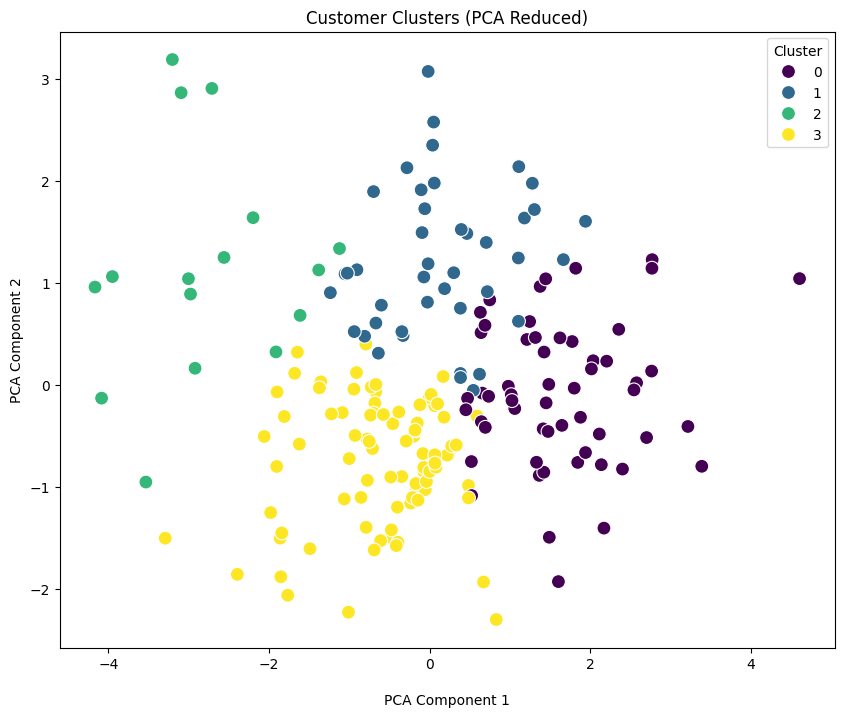

In [27]:
# Visualize Clusters (using PCA for 2D)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(processed_features)
customers_transactions['PCA1'] = reduced_features[:, 0]
customers_transactions['PCA2'] = reduced_features[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customers_transactions, palette='viridis', s=100
)
plt.title('Customer Clusters (PCA Reduced)')
plt.xlabel('\nPCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [28]:
# Summarize Clusters
cluster_summary = customers_transactions.groupby('Cluster').agg({
    'TotalSpent': ['mean', 'median'],
    'AvgSpent': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Recency': ['mean', 'median']
}).reset_index()

print("Cluster Summary:\n")
print(cluster_summary)


Cluster Summary:

  Cluster   TotalSpent              AvgSpent             Frequency         \
                  mean    median        mean      median      mean median   
0       0  5587.837857  5398.875  747.341628  751.438095  7.553571    7.0   
1       1  3792.015714  3850.580  977.418147  971.359000  3.904762    4.0   
2       2  1132.325000   932.365  593.376510  626.850000  1.812500    1.0   
3       3  2349.350353  2509.810  522.726338  557.933333  4.517647    5.0   

      Recency         
         mean median  
0   74.732143   69.0  
1  108.380952  106.0  
2  277.375000  261.5  
3   77.894118   75.0  


In [ ]:
pip install numpy scikit-learn

In [31]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Assuming 'processed_features' is your scaled and transformed dataset
# and 'customers_transactions["Cluster"]' contains the cluster assignments

# Convert cluster labels to array format
cluster_labels = customers_transactions["Cluster"].values

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(processed_features, cluster_labels)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(processed_features, cluster_labels)

print(f"Davies-Bouldin (DB) Index : {db_index}")
print(f"Silhouette Score: {silhouette_avg}")


Davies-Bouldin (DB) Index : 1.2576190797228766
Silhouette Score: 0.24209259180330822


In [33]:
# Save Results
customers_transactions.to_csv('Customer_Clusters.csv', index=False)
cluster_summary.to_csv('Cluster_Summary.csv', index=False)

print("Results saved to Customer_Clusters.csv and Cluster_Summary.csv")


Results saved to Customer_Clusters.csv and Cluster_Summary.csv


In [35]:

import pandas as pd

df = pd.read_csv("C:/Users/HP/Desktop/ZeoTap/Data/Cluster_Summary.csv")

# Create DataFrame
df = pd.DataFrame(data)

# Display the summary statistics table

df


,Cluster,TotalSpent_mean,TotalSpent_median,AvgSpent_mean,AvgSpent_median,Frequency_mean,Frequency_median,Recency_mean,Recency_median
0,0,5587.837857,5398.875,747.341628,751.438095,7.553571,7.0,74.732143,69.0
1,1,3792.015714,3850.580,977.418147,971.359000,3.904762,4.0,108.380952,106.0
2,2,1132.325000,932.365,593.376510,626.850000,1.812500,1.0,277.375000,261.5
3,3,2349.350353,2509.810,522.726338,557.933333,4.517647,5.0,77.894118,75.0


In [38]:
# Display the first 5 records of Customer_Clusters table

import pandas as pd

df = pd.read_csv("C:/Users/HP/Desktop/ZeoTap/Data/Customer_Clusters.csv")
df.head()


,CustomerID,CustomerName,Region,SignupDate,TotalSpent,AvgSpent,Frequency,Recency,Cluster,PCA1,PCA2
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,670.904,5,81,3,0.062718,-0.205091
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,465.685,4,50,3,-0.854862,-1.103799
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,681.345,4,151,3,-0.795155,0.399082
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,669.360,8,30,0,1.841414,-0.760489
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,678.080,3,79,3,-0.944016,-0.042400


# Thank You ! 